Listeria EDA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from pathlib import Path

In [ ]:
ROOT = Path.cwd()
if ROOT.name == "preparation":
    ROOT = ROOT.parent
DATA_PATH = ROOT / "data"

In [ ]:
listeria_metadata = pd.read_csv(DATA_PATH / 'ListeriaSoil_Metadata.csv')
print(listeria_metadata.head())

listeria_data = pd.read_csv(DATA / 'ListeriaSoil_clean.csv')
print("data is ", listeria_data.head())

             Variable                                        Description  \
0            Latitude                  Latitude of the sampling location   
1           Longitude                 Longitude of the sampling location   
2       Elevation (m)  Elevation (m) of the sampling location obtaine...   
3            Moisture  Moisture measure using Methods of Soil Analysi...   
4  Total nitrogen (%)                  Total nitrogen of the soil sample   

        Type  
0  Predictor  
1  Predictor  
2  Predictor  
3  Predictor  
4  Predictor  
data is     index  Latitude  Longitude  Elevation (m)  Moisture  Total nitrogen (%)  \
0      0   35.4740   -83.8701         487.79    0.4280              0.2138   
1      1   35.4850   -83.8675         584.73    0.4241              0.2226   
2      2   35.4815   -83.8587         779.80    0.4425              0.2198   
3      3   35.4844   -83.8381         707.26    1.0843              0.4780   
4      4   35.4727   -83.8513         587.15    0.4674

In [3]:
# pulling out only numeric
listeria_numeric_data = listeria_data.select_dtypes(include='number')

assert len(listeria_data) == len(listeria_numeric_data)

print("col in old: ", len(listeria_data.columns), "  col in new: ", len(listeria_numeric_data.columns), "  length of both is: ", len(listeria_data))
print("got all number")

col in old:  35   col in new:  35   length of both is:  622
got all number


Checking if % add up to 100

In [4]:
# check if wetland, barren, forest, ... add up to 100
# land coverage cols
land_cov_cols = [
    "Open water (%)",
    "Developed open space (< 20% Impervious Cover) (%)",
    "Developed open space (> 20% Impervious Cover) (%)",
    "Barren (%)",
    "Forest (%)",
    "Shrubland (%)",
    "Grassland (%)",
    "Cropland (%)",
    "Pasture (%)",
    "Wetland (%)"
]

listeria_numeric_data["percent_check"] = (listeria_numeric_data[land_cov_cols].sum(axis=1))

# asserting everything adds up to 100
assert np.all(np.isclose(listeria_numeric_data["percent_check"], 100, atol=1e-9))

print(listeria_numeric_data['percent_check'])

listeria_numeric_data = listeria_numeric_data.drop(columns="percent_check")

0       99.9999
1      100.0001
2      100.0000
3       99.9999
4       99.9999
         ...   
617    100.0000
618     99.9998
619    100.0001
620    100.0000
621    100.0001
Name: percent_check, Length: 622, dtype: float64


log versions and distribution checks

In [5]:
# getting columns that are normal or similar to normal (could do skewed, but most cols are skewed)
normal_cols = ["Latitude", "Longitude", "pH", "Max temperature (℃ )","Min temperature (℃ )", "Molybdenum (mg/Kg)", "Wind speed (m/s)"]

# getting all cols that are skewed, but likely wont work with a log transform
arithmatic_skew_cols = ["Precipitation (mm)", "Number of Listeria isolates obtained"]

# getting skewed cols
excluding_cols = set(normal_cols) | set(arithmatic_skew_cols)
skewed_cols = [col for col in listeria_numeric_data.columns if col not in excluding_cols]
print(skewed_cols)



['Elevation (m)', 'Moisture', 'Total nitrogen (%)', 'Total carbon (%)', 'Organic matter (%)', 'Aluminum (mg/Kg)', 'Calcium (mg/Kg)', 'Copper (mg/Kg)', 'Iron (mg/Kg)', 'Potassium (mg/Kg)', 'Magnesium (mg/Kg)', 'Manganese (mg/Kg)', 'Sodium (mg/Kg)', 'Phosphorus (mg/Kg)', 'Sulfur (mg/Kg)', 'Zinc (mg/Kg)', 'Open water (%)', 'Developed open space (< 20% Impervious Cover) (%)', 'Developed open space (> 20% Impervious Cover) (%)', 'Barren (%)', 'Forest (%)', 'Shrubland (%)', 'Grassland (%)', 'Cropland (%)', 'Pasture (%)', 'Wetland (%)']


26


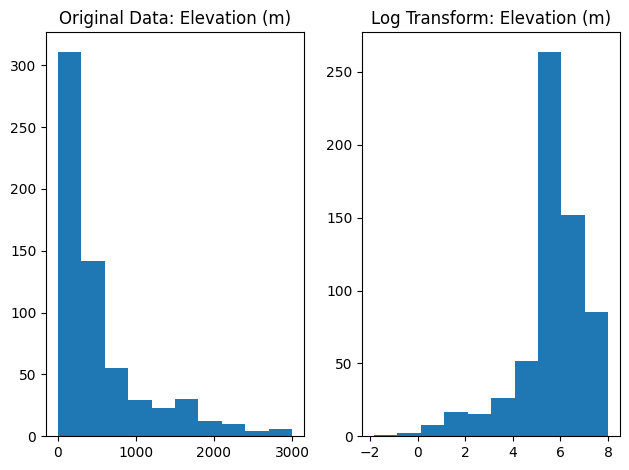

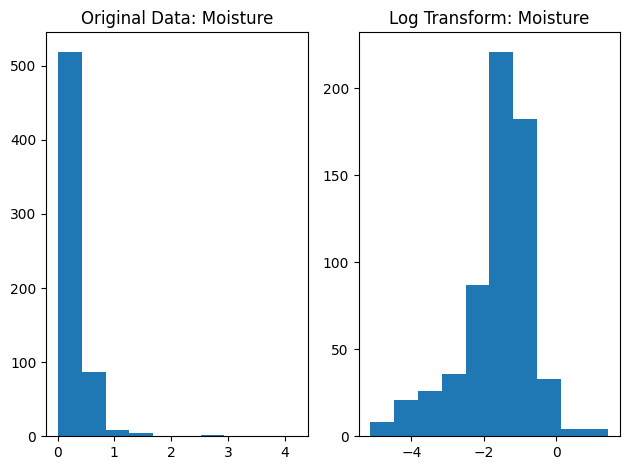

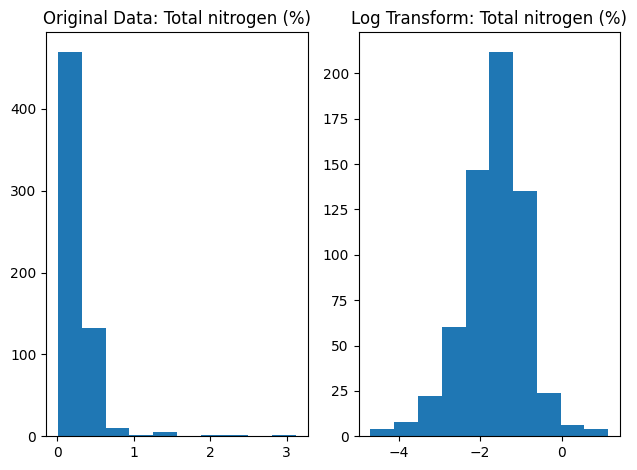

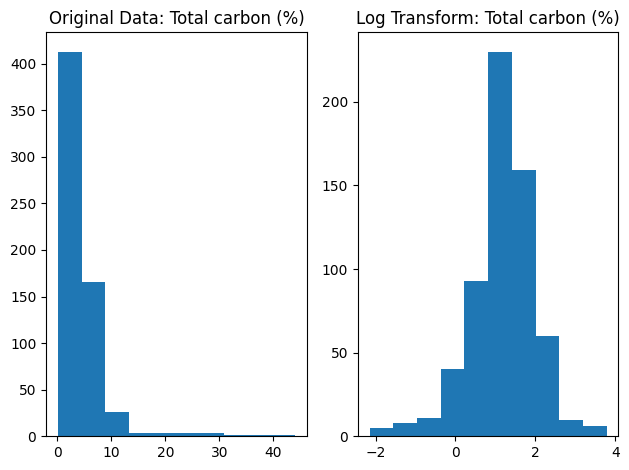

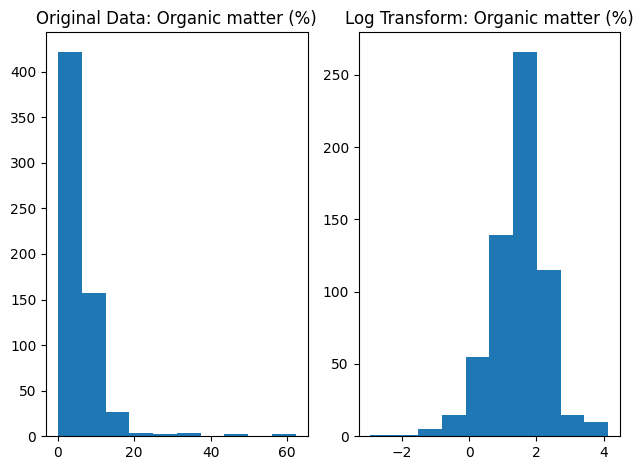

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


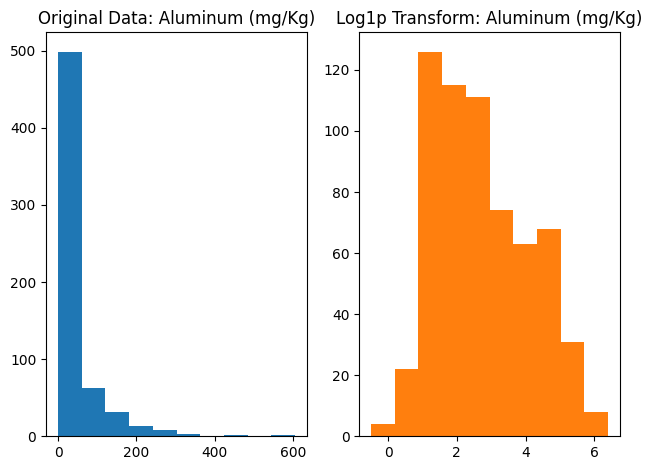

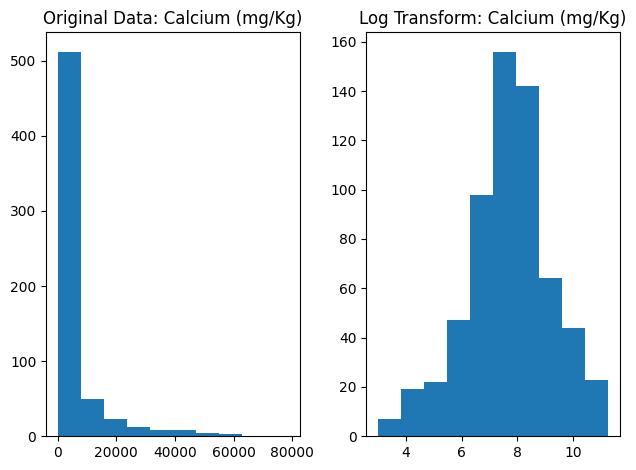

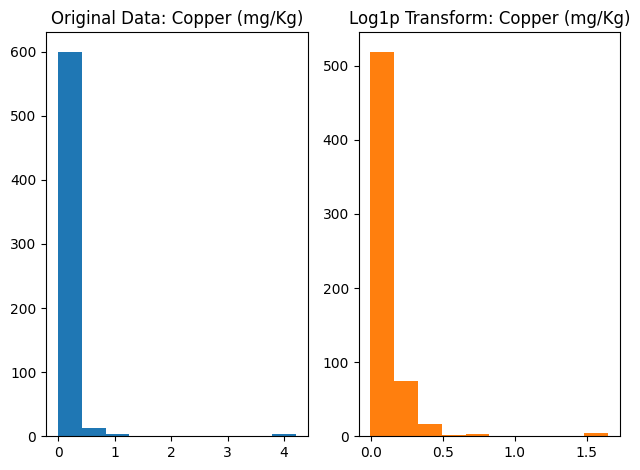

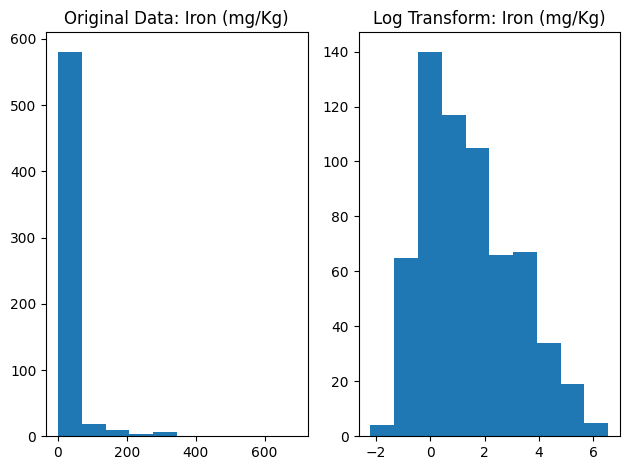

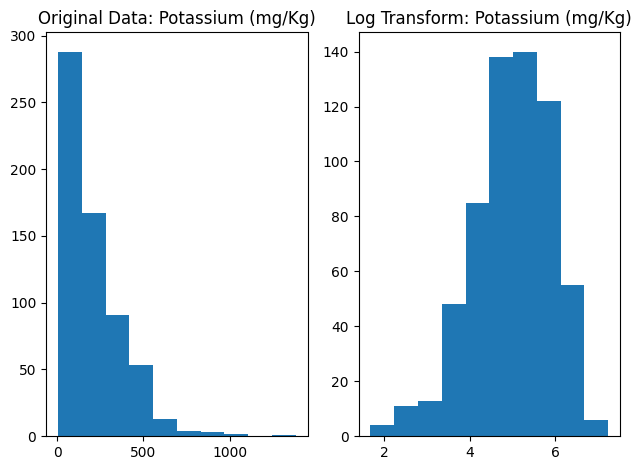

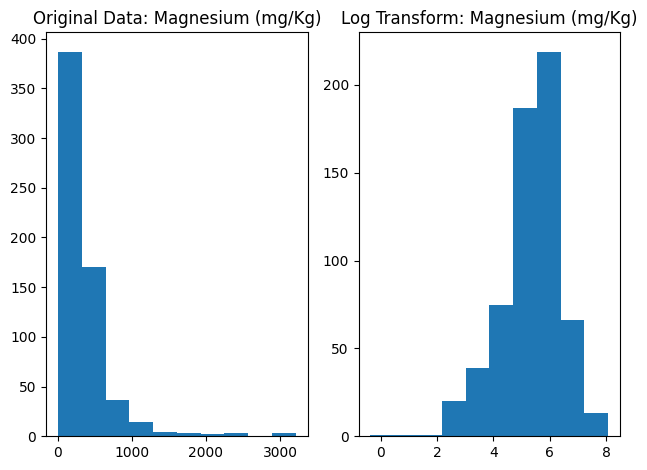

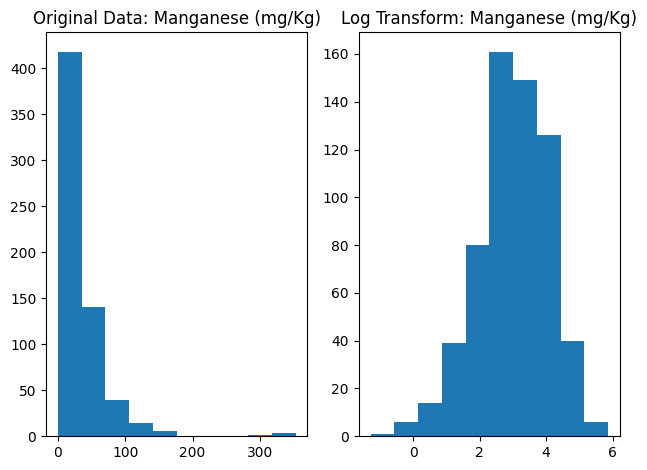

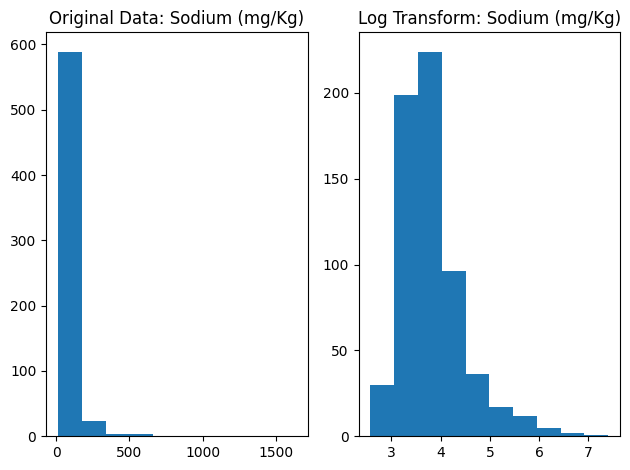

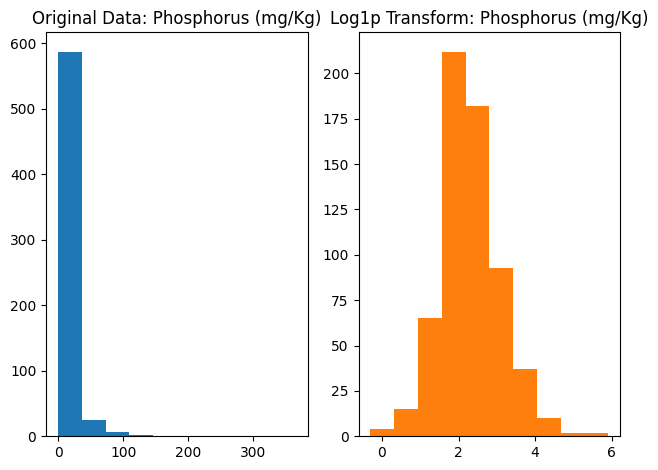

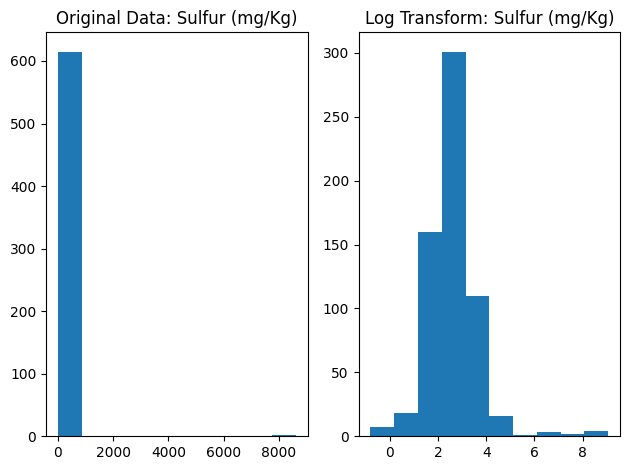

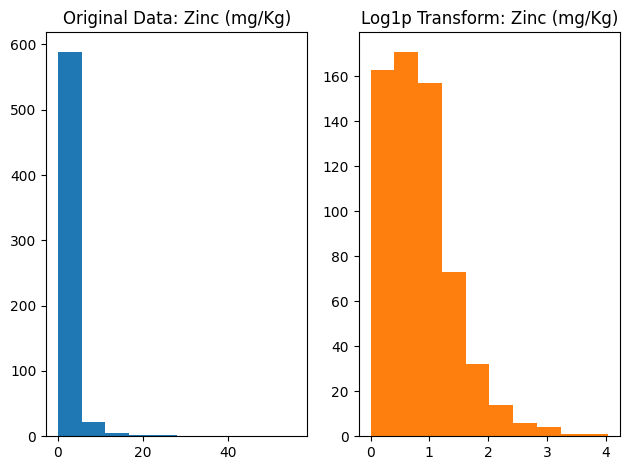

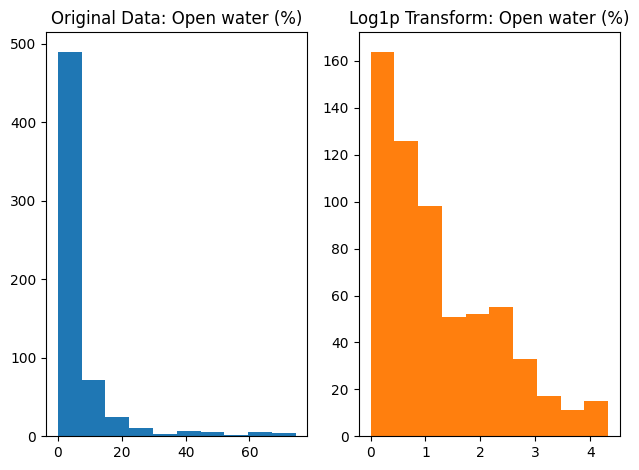

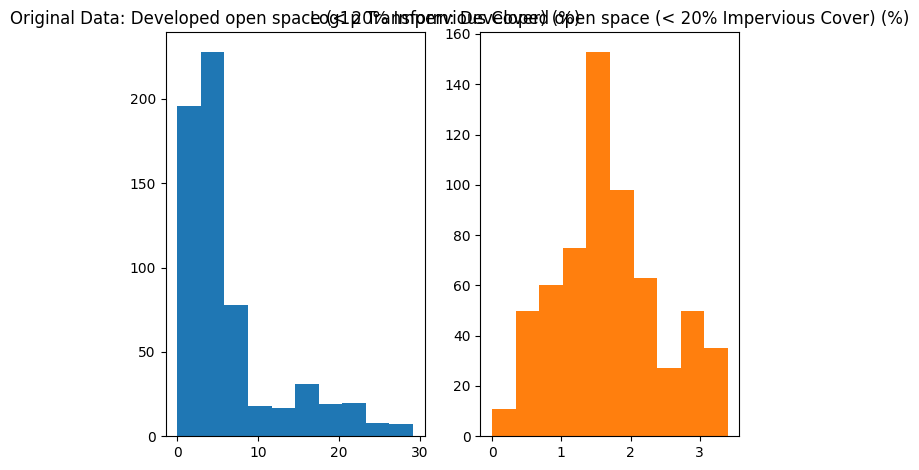

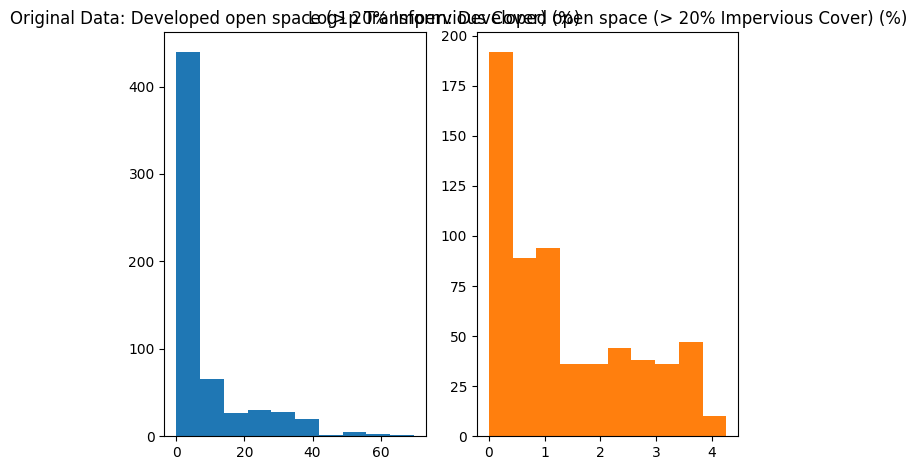

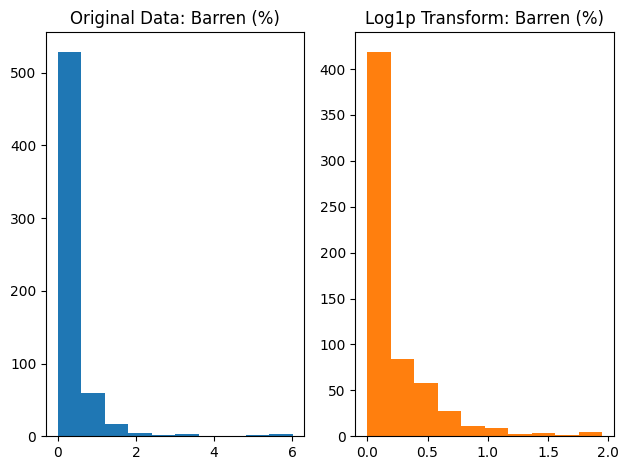

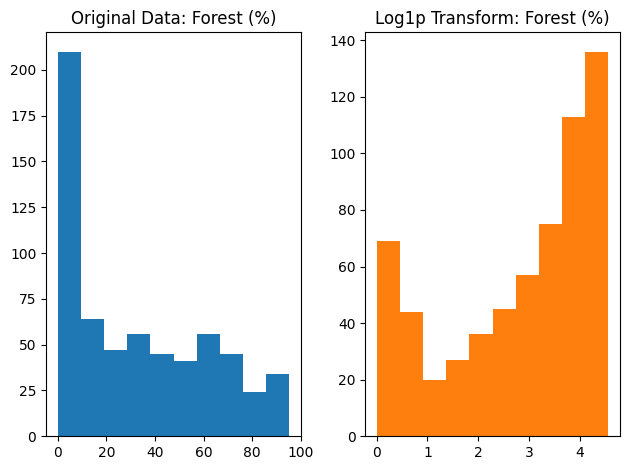

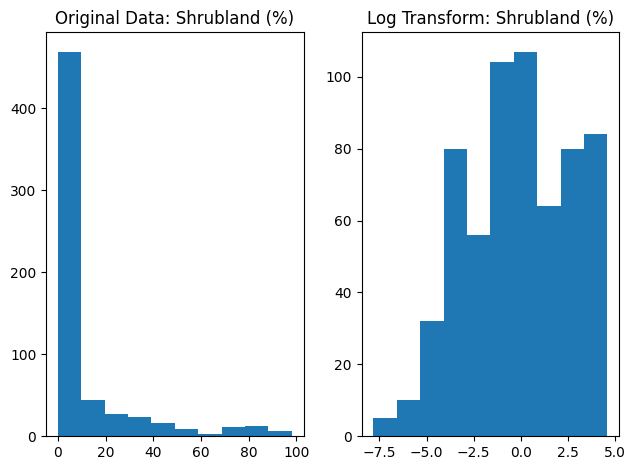

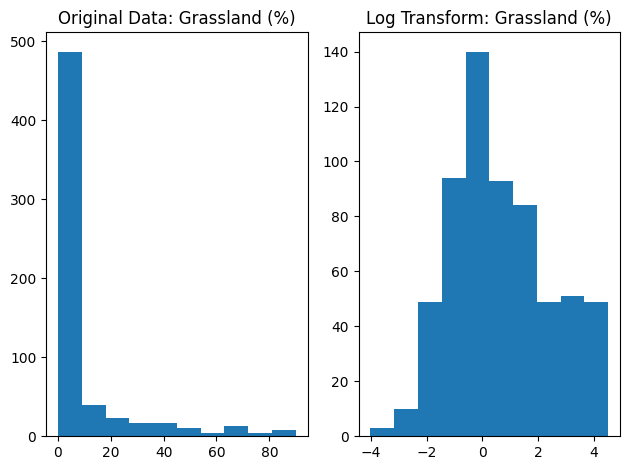

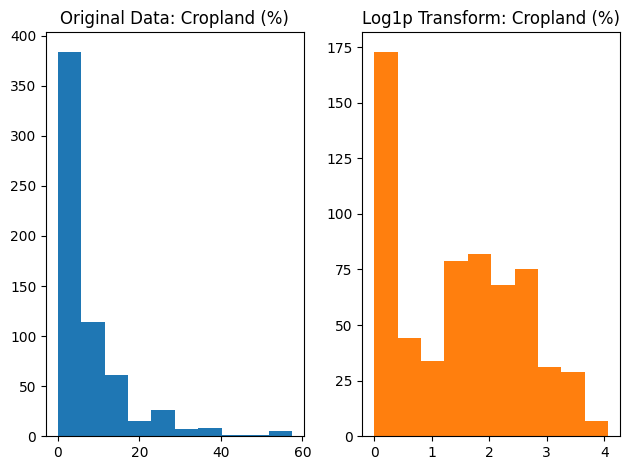

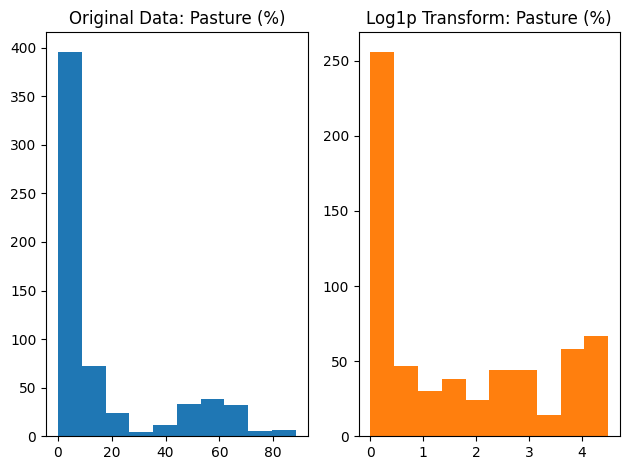

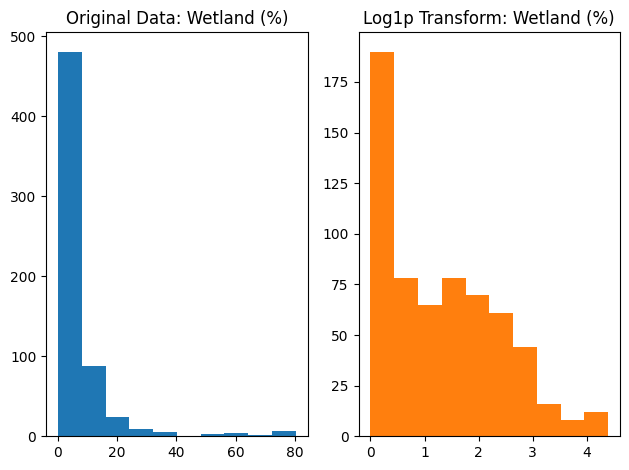

In [6]:
print(len(skewed_cols))

for col in skewed_cols:
    plt.subplot(1, 2, 1)
    plt.hist(listeria_numeric_data[col])
    plt.title(f'Original Data: {col}')

    logged_data = None
    try: 
        logged_data = np.log(listeria_numeric_data[col])
        # plotting
        plt.subplot(1, 2, 2)
        plt.hist(logged_data)
        plt.title(f'Log Transform: {col}')
    except:
        logged_data = np.log1p(listeria_numeric_data[col])
        # plotting
        plt.subplot(1, 2, 2)
        plt.hist(logged_data)
        plt.title(f'Log1p Transform: {col}')

    plt.tight_layout()
    plt.show()

In [7]:
# manual entry of columns for log distribution based on histograms above

# manually entering all of ones not to use because list is shorter
transformed_not_enough = {
    "Zinc (mg/Kg)": "likely needs a second log transformation",
    "Elevation (m)": "mostly just flipped the distribution skew",
    "Sodium (mg/Kg)": "still skewed, but less so",
    "Copper (mg/Kg)": "most values are 0, only <10 outliers",
    "Wetland (%)": "0 heavy, and the rest is a really flat normal",
    "Open water (%)": "heavy 0, and rest is almost uniform/steep then slow log",
    "Developed open space (> 20% Impervious Cover) (%)": "heavy 0, rest is almost uniform",
    "Barren (%)": "0 heavy with a few outliers",
    "Forest (%)": "almost makes outliers, steep 0, then steep increase",
    "Cropland (%)": "heavy 0, the rest almost normal",
    "Pasture (%)": "still very 0 heavy, and almost a increasing pattern after 0",
}

# notes on which of the bad we should still try with a log transform
transform_bad_but_helpful = ["Elevation (m)", "Sodium (mg/Kg)", "Open water (%)", "Developed open space (> 20% Impervious Cover) (%)", "Wetland (%)", "Cropland (%)"]

# noting which need to be double transformed with log
double_transform = "Zinc (mg/Kg)"

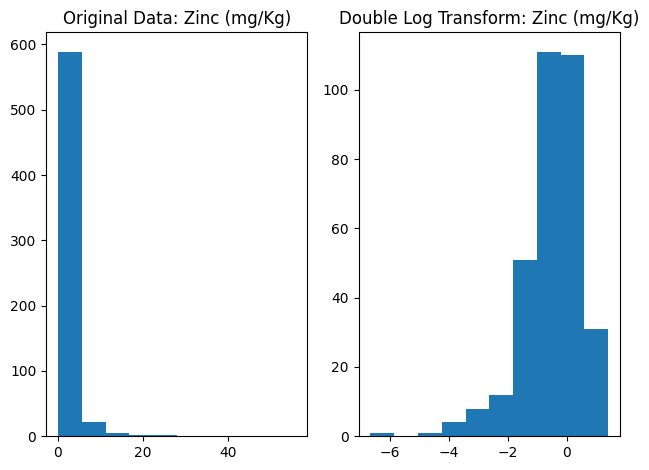

In [8]:
# plotting to see if double transform worked
plt.subplot(1, 2, 1)
plt.hist(listeria_numeric_data[double_transform])
plt.title(f'Original Data: {double_transform}')

logged_data = None
try: 
    logged_data = np.log(np.log(listeria_numeric_data[double_transform]))
    # plotting
    plt.subplot(1, 2, 2)
    plt.hist(logged_data)
    plt.title(f'Double Log Transform: {double_transform}')
except:
    # filling in all negative values with 0 instead of actual (because neg values are biologically impossible)
    cleaned_col = [row_val if row_val > 0 else 1e-9 for row_val in listeria_numeric_data[double_transform]]
    logged_data = np.log(np.log(cleaned_col))
    # drop non finite for graphing purposes:
    logged_data = logged_data.clip(1e-6) 
    logged_data = logged_data[np.isfinite(logged_data)]
    if np.any(logged_data is np.inf):
        print("still problem")
    # plotting
    plt.subplot(1, 2, 2)
    plt.hist(logged_data)
    plt.title(f'Double Log Transform: {double_transform}')

plt.tight_layout()
plt.show()

In [9]:
# to transform = (not the ones in the bad list) + (the ones in the bad but still helpful list)
to_transform = (set(skewed_cols) - set(transformed_not_enough.keys())) | set(transform_bad_but_helpful)
assert "Calcium (mg/Kg)" in to_transform
assert "Elevation (m)" in to_transform
assert "Pasture (%)" not in to_transform

# adding a log version to every one in the list above
for col in to_transform:
    print(col)
    listeria_numeric_data[f"log of {col}"] = np.log(listeria_numeric_data[col])

# dropping all non-log versions
listeria_numeric_data = listeria_numeric_data.drop(columns=to_transform)
assert "Calcium (mg/Kg)" not in listeria_numeric_data.columns
assert "Elevation (m)" not in listeria_numeric_data.columns
assert "Pasture (%)" in listeria_numeric_data.columns


# completing the double log transform
listeria_numeric_data[f"double log of {double_transform}"] = np.log(np.log(listeria_numeric_data[double_transform]))

# dropping double log transform data
listeria_numeric_data = listeria_numeric_data.drop(columns=double_transform)

Grassland (%)
Sulfur (mg/Kg)
Moisture
Manganese (mg/Kg)
Elevation (m)
Organic matter (%)
Phosphorus (mg/Kg)
Iron (mg/Kg)
Cropland (%)
Wetland (%)
Sodium (mg/Kg)
Calcium (mg/Kg)
Developed open space (< 20% Impervious Cover) (%)
Magnesium (mg/Kg)
Shrubland (%)
Open water (%)
Total carbon (%)
Developed open space (> 20% Impervious Cover) (%)
Aluminum (mg/Kg)
Potassium (mg/Kg)
Total nitrogen (%)


C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: 

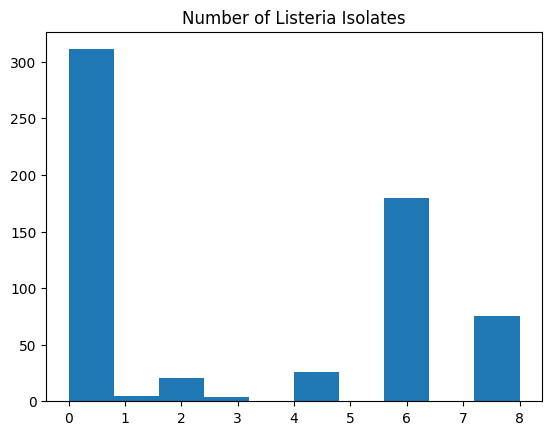

In [10]:
plt.hist(listeria_numeric_data["Number of Listeria isolates obtained"])
plt.title("Number of Listeria Isolates")
plt.show()

Summary Stats

In [11]:
# getting all mean, median, mode, min, and max from each numeric column
summary_stats = pd.DataFrame({
    "mean":   listeria_numeric_data.mean(),
    "median": listeria_numeric_data.median(),
    "mode":   listeria_numeric_data.mode().iloc[0], # NOTE: this only takes one of the modes if there are multiple
    "min":    listeria_numeric_data.min(),
    "max":    listeria_numeric_data.max(),
})

print(summary_stats.head())

                         mean    median     mode       min      max
Latitude            39.511448  40.20915  32.3697   26.0720  48.6027
Longitude          -94.984605 -93.72400 -93.7348 -123.5447 -67.0275
pH                   6.388043   6.45950   7.4200    3.6000   8.8070
Copper (mg/Kg)       0.136051   0.07205   0.0000   -0.0044   4.2065
Molybdenum (mg/Kg)   0.033646   0.03020   0.0000   -0.0834   0.2979


Box and whisker plots 

0      6.0
1      4.0
2      6.0
3      8.0
4      6.0
      ... 
610    6.0
611    6.0
618    6.0
619    6.0
620    6.0
Name: Number of Listeria isolates obtained, Length: 311, dtype: float64


C:\Users\ameli\AppData\Local\Temp\ipykernel_17092\1280073700.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([listeria_data['Number of Listeria isolates obtained'], above_zero_only, listeria_numeric_data['binary_listeria_presense']], labels=['All values', '>0 only', 'binary presense absense'])


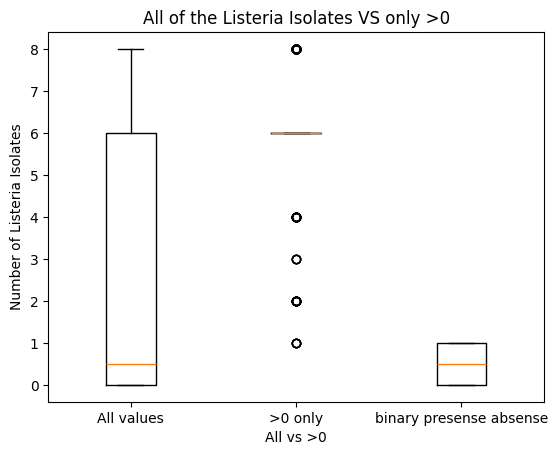

In [12]:
# box plot for all listeria values vs only >0 vs binary (presense absense)
# gettomg only above 0
above_zero_only = listeria_data['Number of Listeria isolates obtained'][listeria_data['Number of Listeria isolates obtained'] > 0]
print(above_zero_only)
# getting only binary result
listeria_numeric_data['binary_listeria_presense'] = [row_val if row_val == 0 else 1 for row_val in listeria_numeric_data['Number of Listeria isolates obtained']]

plt.boxplot([listeria_data['Number of Listeria isolates obtained'], above_zero_only, listeria_numeric_data['binary_listeria_presense']], labels=['All values', '>0 only', 'binary presense absense'])


# plotting info
plt.title('All of the Listeria Isolates VS only >0')
plt.ylabel('Number of Listeria Isolates')
plt.xlabel('All vs >0')
plt.show()

# NOTE: it is okay that there are only circles, this is because 
# most of the data ended up being 6


Correlations

<Axes: >

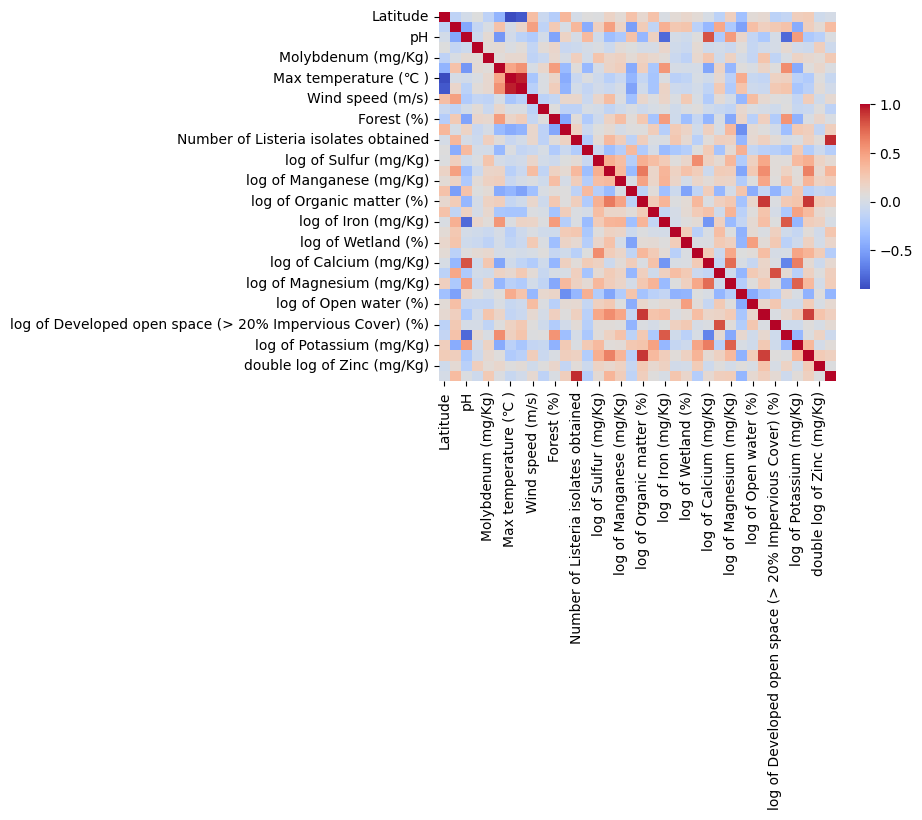

In [13]:
# all variables
corr_matrix = listeria_numeric_data.corr()

# building heatmap
sns.heatmap(
    corr_matrix,
    annot=False, # remove the numbers above the heat value
    cmap='coolwarm', # color pallate
    cbar_kws={'shrink': .5} # adjusting color bar size
)

In [28]:
# new catagories of variables

weather_variables = [
    "Latitude",
    "Longitude",
    "log of Elevation (m)",
    "log of Moisture",
    "Precipitation (mm)",
    "Max temperature (℃ )",
    "Min temperature (℃ )",
    "Wind speed (m/s)",
    "Number of Listeria isolates obtained",
    "binary_listeria_presense"
]

soil_variables = [
    "Latitude",
    "Longitude",
    "log of Total nitrogen (%)",
    "log of Total carbon (%)",
    "pH",
    "log of Organic matter (%)",
    "log of Aluminum (mg/Kg)",
    "log of Calcium (mg/Kg)",
    "Copper (mg/Kg)",
    "log of Iron (mg/Kg)",
    "log of Potassium (mg/Kg)",
    "log of Magnesium (mg/Kg)",
    "log of Manganese (mg/Kg)",
    "Molybdenum (mg/Kg)",
    "log of Sodium (mg/Kg)",
    "log of Phosphorus (mg/Kg)",
    "log of Sulfur (mg/Kg)",
    "double log of Zinc (mg/Kg)",
    "Number of Listeria isolates obtained",
    "binary_listeria_presense"
]

land_cover_variables = [
    "Latitude",
    "Longitude",
    "log of Elevation (m)",
    "log of Open water (%)",
    "log of Developed open space (< 20% Impervious Cover) (%)",
    "log of Developed open space (> 20% Impervious Cover) (%)",
    "Barren (%)",
    "Forest (%)",
    "log of Shrubland (%)",
    "log of Grassland (%)",
    "log of Cropland (%)",
    "Pasture (%)",
    "log of Wetland (%)",
    "Number of Listeria isolates obtained",
    "binary_listeria_presense"
]

<Axes: >

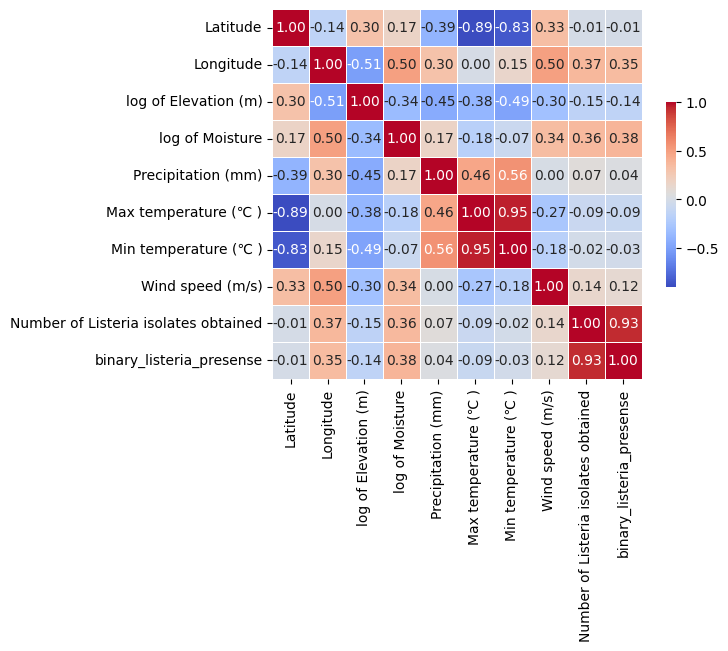

In [15]:
# just weather varriables
corr_matrix = listeria_numeric_data[weather_variables].corr()

# building heatmap
sns.heatmap(
    corr_matrix,
    annot=True, # add the numbers above the heat value
    cmap='coolwarm', # color pallate
    fmt='.2f', # all correlations to 2 decimal places
    linewidths=.5, # add lines between cells
    square=True, # cells -> square
    cbar_kws={'shrink': .5} # adjusting color bar size
)

<Axes: >

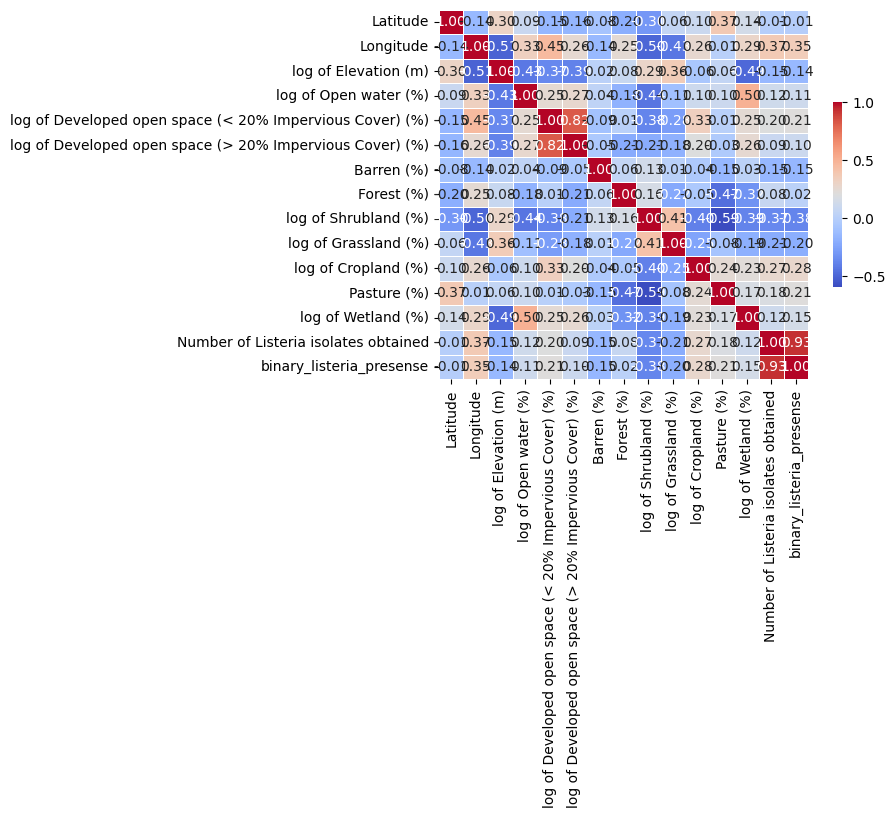

In [22]:
# just landcover variables
corr_matrix = listeria_numeric_data[land_cover_variables].corr()

# building heatmap
sns.heatmap(
    corr_matrix,
    annot=True, # add the numbers above the heat value
    cmap='coolwarm', # color pallate
    fmt='.2f', # all correlations to 2 decimal places
    linewidths=.5, # add lines between cells
    square=True, # cells -> square
    cbar_kws={'shrink': .5} # adjusting color bar size
)

<Axes: >

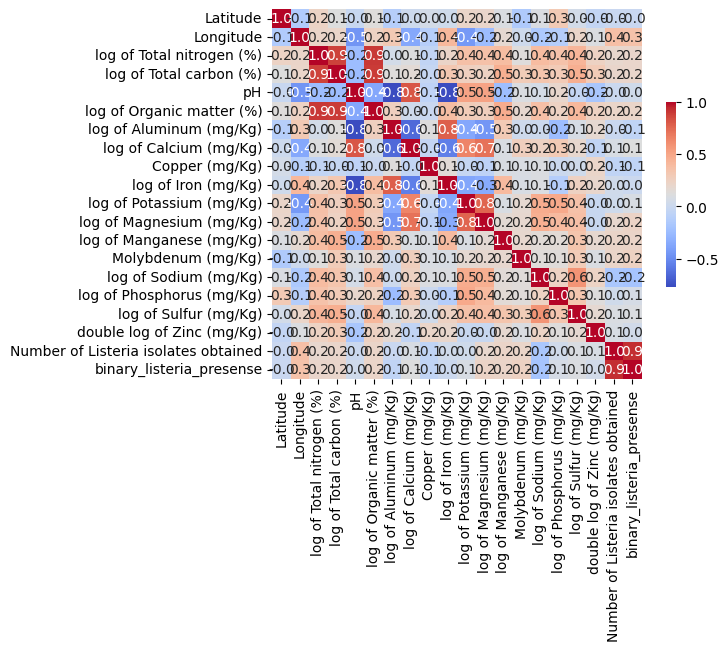

In [29]:
# just soil variables
corr_matrix = listeria_numeric_data[soil_variables].corr()

# building heatmap
sns.heatmap(
    corr_matrix,
    annot=True, # add the numbers above the heat value
    cmap='coolwarm', # color pallate
    fmt='.1f', # all correlations to 2 decimal places
    # linewidths=.5, # add lines between cells
    square=True, # cells -> square
    cbar_kws={'shrink': .5} # adjusting color bar size
)

scaling a copy of data for comparison and use

In [30]:
scaler = StandardScaler()

# getting rid of the logged cols with inf
only_finite_numeric = [col for col in listeria_numeric_data.columns if np.all(np.isfinite(listeria_numeric_data[col]))]

print("num cols: ", len(only_finite_numeric), " rows: ", len(only_finite_numeric))
print(listeria_numeric_data[only_finite_numeric].head())
scaled_listeria_num_data = scaler.fit_transform(listeria_numeric_data[only_finite_numeric])
print(scaled_listeria_num_data[:5, :5])
print("SHAPE: ", scaled_listeria_num_data.shape)

num cols:  28  rows:  28
   Latitude  Longitude     pH  Copper (mg/Kg)  Molybdenum (mg/Kg)  \
0   35.4740   -83.8701  4.639          0.4037              0.2301   
1   35.4850   -83.8675  4.677          0.3764              0.2424   
2   35.4815   -83.8587  4.102          0.5256              0.2979   
3   35.4844   -83.8381  5.396          0.4162              0.2625   
4   35.4727   -83.8513  4.486          0.4159              0.2333   

   Precipitation (mm)  Max temperature (℃ )  Min temperature (℃ )  \
0             173.575                7.7397               -3.0623   
1             173.575                7.7397               -3.0623   
2             173.575                7.7397               -3.0623   
3             173.575                7.7397               -3.0623   
4             173.575                7.7397               -3.0623   

   Wind speed (m/s)  Barren (%)  ...  log of Organic matter (%)  \
0            3.6666      0.0275  ...                   1.994605   
1          

feature variance

In [31]:
feature_variance = listeria_numeric_data.var().sort_values(ascending=False)
print("without scaled version")
print(feature_variance.head(10))

scaled_feature_variance = np.sort(scaled_listeria_num_data.var(axis=0))
print("scaled version")
print("this should all be 1 due to the scalar: ", scaled_feature_variance[:10])

without scaled version
Precipitation (mm)                      4446.217599
Forest (%)                               832.369833
Pasture (%)                              521.803027
Longitude                                172.887240
Max temperature (℃ )                      58.957951
Min temperature (℃ )                      54.947563
Latitude                                  29.129245
Number of Listeria isolates obtained      10.241787
log of Shrubland (%)                       7.620186
log of Grassland (%)                       3.254051
dtype: float64
scaled version
this should all be 1 due to the scalar:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


PCA analysis for variance (with and without scaling)

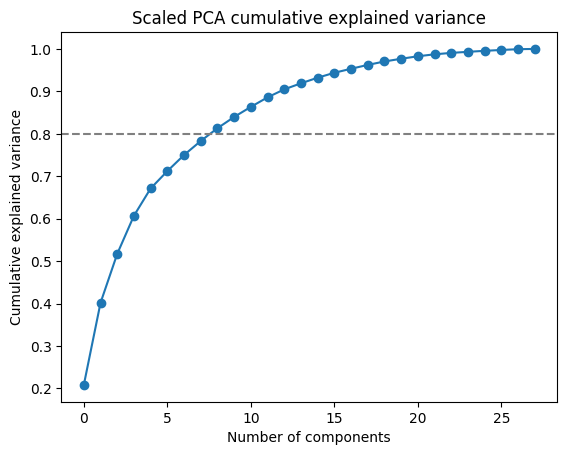

                                           PC1       PC2       PC3       PC4  \
Latitude                              0.041615  0.238949 -0.330890 -0.262306   
Longitude                             0.269383 -0.125250 -0.158099  0.221174   
pH                                   -0.247430  0.240500  0.138430  0.199067   
Copper (mg/Kg)                       -0.001606 -0.043665  0.059240 -0.142881   
Molybdenum (mg/Kg)                    0.081793  0.058343  0.228734  0.086723   
Precipitation (mm)                    0.175206 -0.290842  0.124686 -0.004261   
Max temperature (℃ )                 -0.050286 -0.251916  0.377214  0.196534   
Min temperature (℃ )                  0.013985 -0.277143  0.328965  0.213630   
Wind speed (m/s)                      0.158253  0.033243 -0.242700  0.052334   
Barren (%)                           -0.043177 -0.065198  0.054772 -0.158362   
Forest (%)                            0.144039 -0.231697  0.050239 -0.175951   
Pasture (%)                           0.

In [32]:
# with scaling
scaled_pca_fun = PCA()
scaled_pca_data = scaled_pca_fun.fit_transform(scaled_listeria_num_data)

# getting the cummulative sum (cum sum) of the variance to see how many PCA components we need and, in general, how much variation
explained_var = np.cumsum(scaled_pca_fun.explained_variance_ratio_)

# making graph easier to look at
plt.plot(explained_var, marker='o')
plt.axhline(0.8, linestyle='--', color='gray')
# labeling axis and title
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Scaled PCA cumulative explained variance')
# displaying
plt.show()

# getting which variables drove the variance in the pca function
loadings = pd.DataFrame(
    scaled_pca_fun.components_.T,
    index=only_finite_numeric, # using listeria data instead of the scaled bc the scaled is a np array, and should align with the original
    columns=[f"PC{i+1}" for i in range(scaled_pca_fun.n_components_)]
)

loadings[['PC1', 'PC2']].sort_values('PC1', key=np.abs, ascending=False).head(10)
print(loadings)

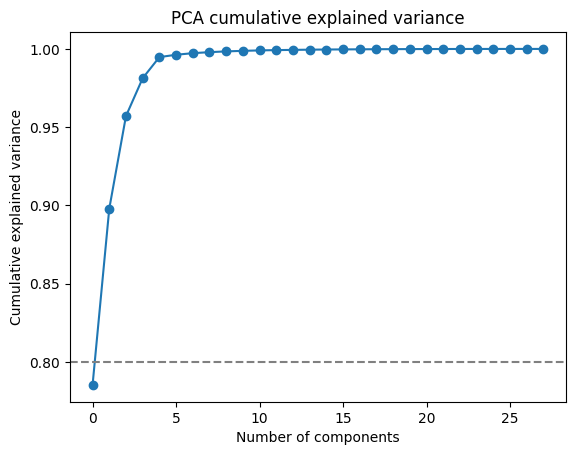

                                           PC1       PC2       PC3       PC4  \
Latitude                             -0.032020 -0.014154  0.092897 -0.069481   
Longitude                             0.058999 -0.006324  0.241775  0.951166   
pH                                   -0.009793 -0.004645 -0.016507 -0.021311   
Copper (mg/Kg)                        0.000590  0.001202  0.000126 -0.005063   
Molybdenum (mg/Kg)                    0.000040  0.000074  0.000141 -0.000101   
Precipitation (mm)                    0.952927 -0.283726 -0.020866 -0.059776   
Max temperature (℃ )                  0.052271  0.005634 -0.186779  0.018081   
Min temperature (℃ )                  0.060340 -0.006229 -0.135398  0.073374   
Wind speed (m/s)                     -0.000123 -0.004520  0.006469  0.028691   
Barren (%)                            0.001357  0.000564 -0.004770 -0.008758   
Forest (%)                            0.247524  0.786834  0.530873 -0.143474   
Pasture (%)                          -0.

In [33]:
# original data
pca_fun = PCA()
pca_data = pca_fun.fit_transform(listeria_numeric_data[only_finite_numeric])

# getting the cummulative sum (cum sum) of the variance to see how many PCA components we need and, in general, how much variation
explained_var = np.cumsum(pca_fun.explained_variance_ratio_)

# making graph easier to look at
plt.plot(explained_var, marker='o')
plt.axhline(0.8, linestyle='--', color='gray')
# labeling axis and title
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA cumulative explained variance')
# displaying
plt.show()

# getting which variables drove the variance in the pca function
loadings = pd.DataFrame(
    pca_fun.components_.T,
    index=only_finite_numeric,
    columns=[f"PC{i+1}" for i in range(pca_fun.n_components_)]
)

loadings[['PC1', 'PC2']].sort_values('PC1', key=np.abs, ascending=False).head(10)
print(loadings)

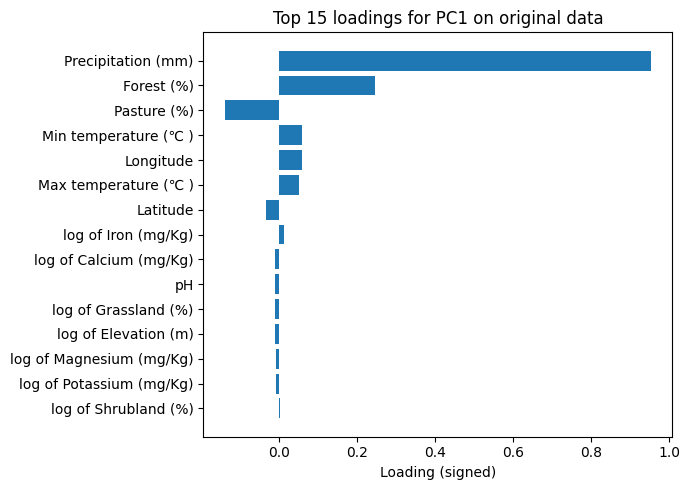

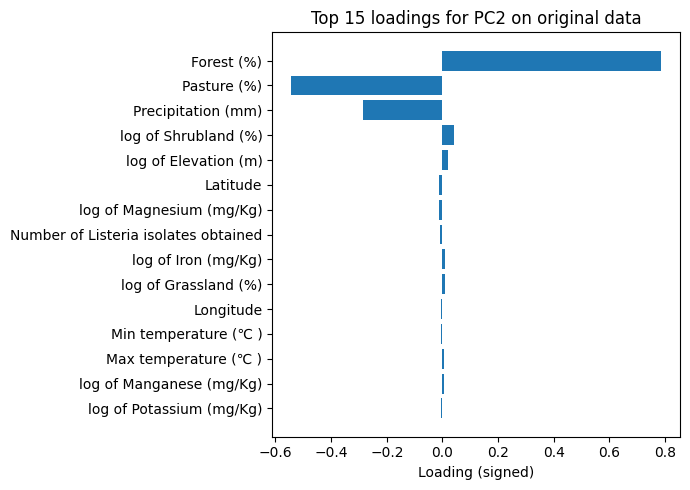

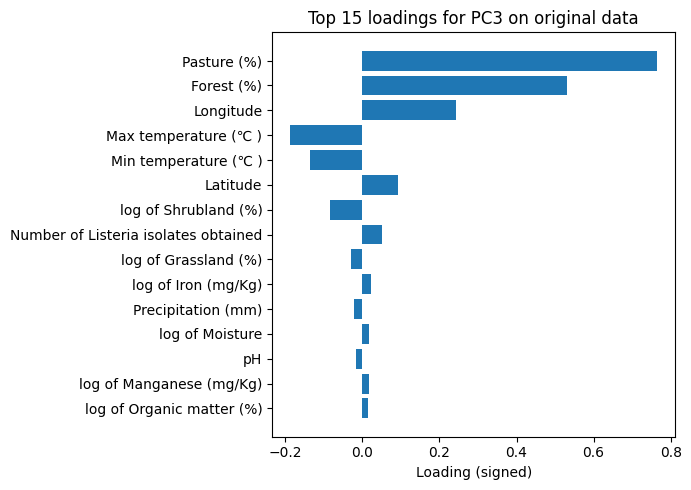

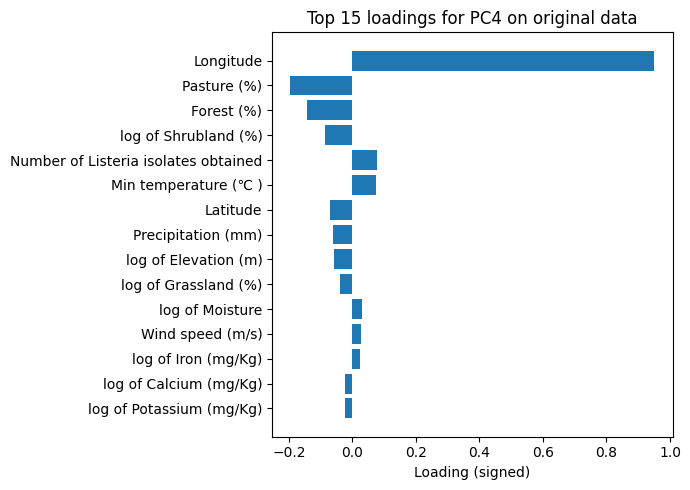

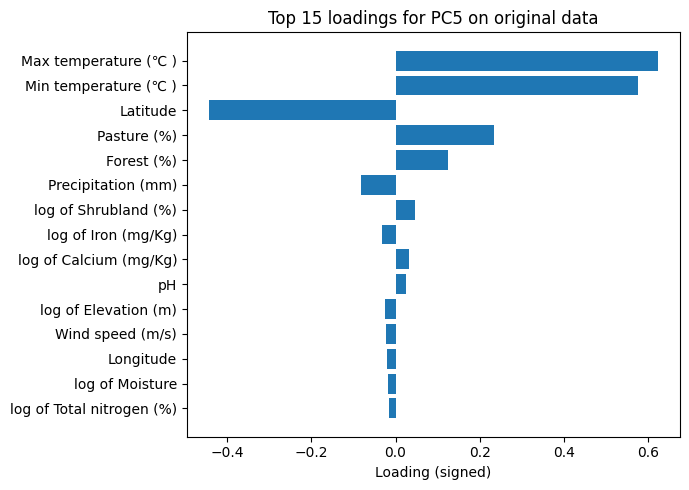

In [54]:
# visuallizing the loadings
# loadings is your DataFrame with index=feature names, columns=PC1, PC2, ...

def plot_top_loadings(loadings, pc="PC1", top_n=15):
    s = loadings[pc].sort_values(key=np.abs, ascending=False).head(top_n)
    plt.figure(figsize=(7, 5))
    plt.barh(s.index[::-1], s.values[::-1])
    plt.xlabel("Loading (signed)")
    plt.title(f"Top {top_n} loadings for {pc} on original data")
    plt.tight_layout()
    plt.show()

plot_top_loadings(loadings, "PC1", top_n=15)
plot_top_loadings(loadings, "PC2", top_n=15)
plot_top_loadings(loadings, "PC3", top_n=15)
plot_top_loadings(loadings, "PC4", top_n=15)
plot_top_loadings(loadings, "PC5", top_n=15)


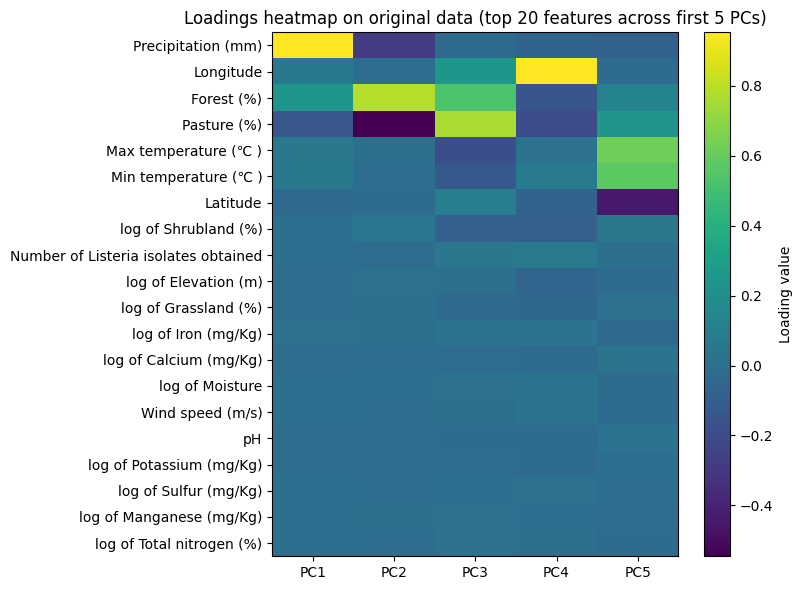

In [35]:
N_PCS = 5
top_features = (
    loadings[[f"PC{i+1}" for i in range(N_PCS)]]
    .abs()
    .max(axis=1)
    .sort_values(ascending=False)
    .head(20)
    .index
)

plt.figure(figsize=(8, 6))
plt.imshow(loadings.loc[top_features, [f"PC{i+1}" for i in range(N_PCS)]], aspect="auto")
plt.yticks(range(len(top_features)), top_features)
plt.xticks(range(N_PCS), [f"PC{i+1}" for i in range(N_PCS)])
plt.colorbar(label="Loading value")
plt.title("Loadings heatmap on original data (top 20 features across first 5 PCs)")
plt.tight_layout()
plt.show()

Cluster (testing with and without standard scaling bc clusters are distance based and the outlier skew could throw off the data)

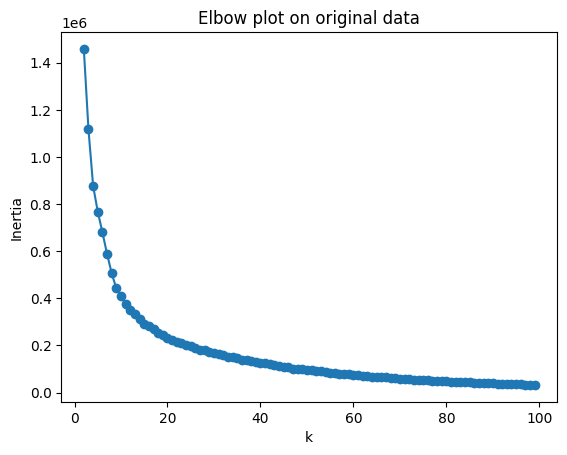

In [59]:
# without standard scaling

# setting starting variables
speed = [] # inertia, this is one of the things we care about for clusters
K = range(2, 100) # how many clusters testing over

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(listeria_numeric_data[only_finite_numeric])
    speed.append(km.inertia_)

# displaying plot
plt.plot(K, speed, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow plot on original data')
plt.show()

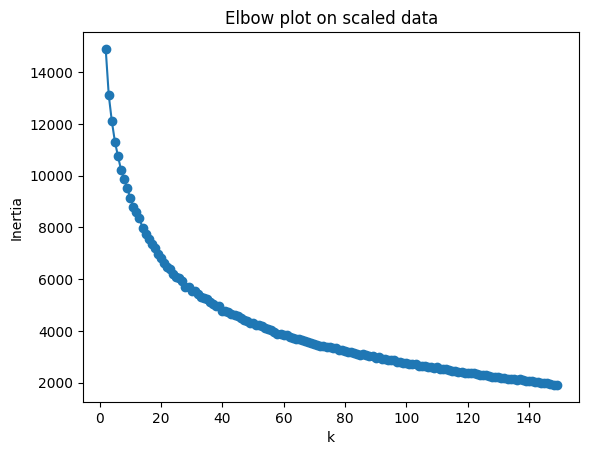

In [37]:
# standard scaling

# setting starting variables
speed = [] # inertia, this is one of the things we care about for clusters
K = range(2, 150) # how many clusters testing over

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(scaled_listeria_num_data)
    speed.append(km.inertia_)

# displaying plot
plt.plot(K, speed, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow plot on scaled data')
plt.show()

Testing for heirerarchical clustering because there seems to be more needed on cluster strucuture here

In [38]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

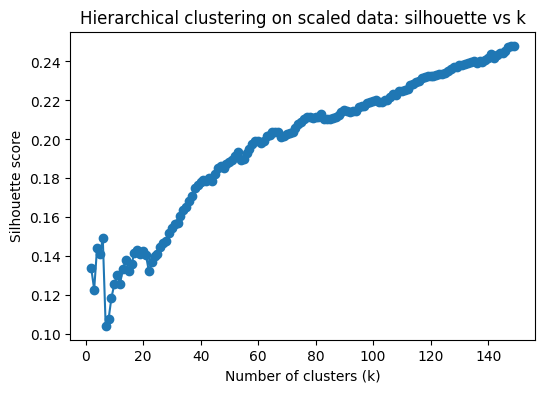

In [39]:
# with scaled data

k_range = range(2, 150)
sil_scores = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(scaled_listeria_num_data)
    sil_scores.append(silhouette_score(scaled_listeria_num_data, labels))

plt.figure(figsize=(6,4))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Hierarchical clustering on scaled data: silhouette vs k")
plt.show()

# NOTE, none of these values unless approaching k = 1/2 or all of original data is not good

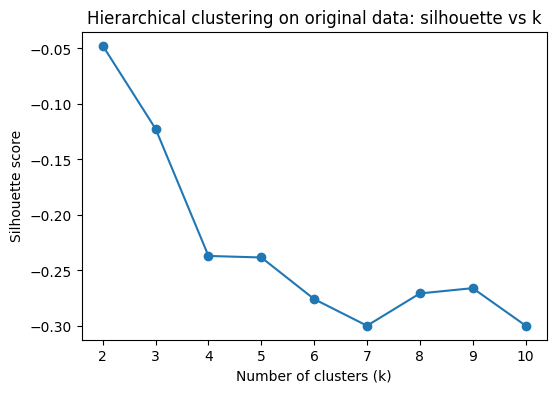

In [40]:
# original data

k_range = range(2, 11)
sil_scores = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(listeria_numeric_data[only_finite_numeric])
    sil_scores.append(silhouette_score(listeria_data, labels))

plt.figure(figsize=(6,4))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Hierarchical clustering on original data: silhouette vs k")
plt.show()

# note, supprisingly, 2 clusters actually performed okay, and was close to a 1, which means points were very well seperated

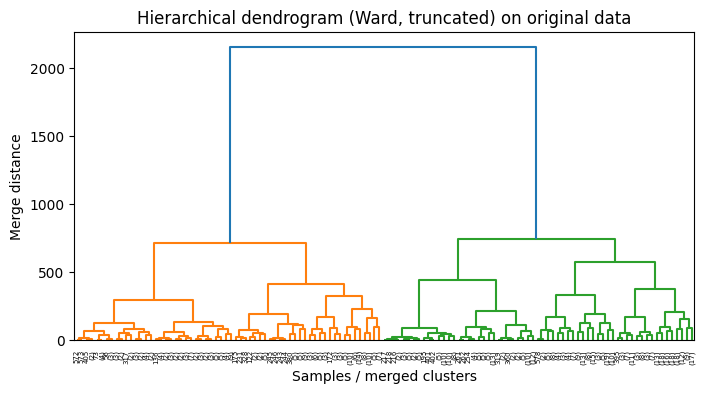

In [41]:
# original data
Z = linkage(listeria_numeric_data[only_finite_numeric], method="ward")

plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode="level", p=6)
plt.title("Hierarchical dendrogram (Ward, truncated) on original data")
plt.xlabel("Samples / merged clusters")
plt.ylabel("Merge distance")
plt.show()


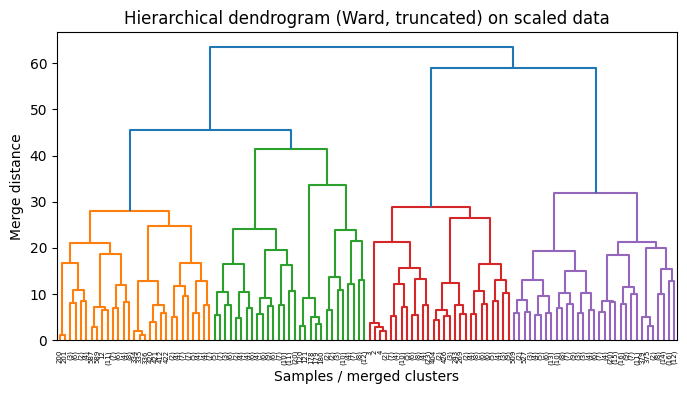

In [42]:
# scaled data
Z = linkage(scaled_listeria_num_data, method="ward")

plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode="level", p=6)
plt.title("Hierarchical dendrogram (Ward, truncated) on scaled data")
plt.xlabel("Samples / merged clusters")
plt.ylabel("Merge distance")
plt.show()


Observing how the PCA data fits with the best fit cluster derrived from the elbow curve
- if the clusters are overlapping in pca data, probably less meaningful clustering, or weak structure.
- try applying on regular data as well (with no pca reduction)

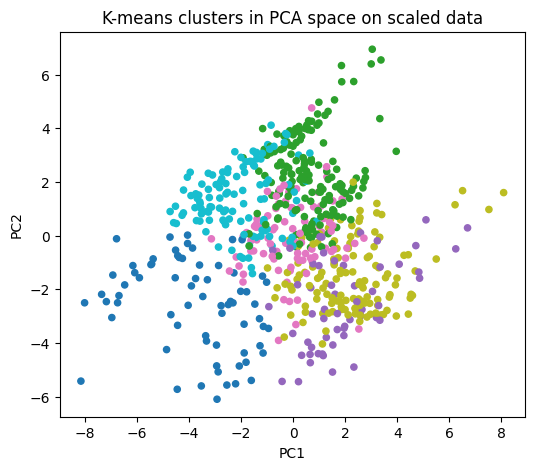

In [62]:
# scaled data

# getting labels for most reasonable fit
k = 6  # example
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(scaled_listeria_num_data)

listeria_numeric_data['scaled_cluster_kmeans'] = labels


plt.figure(figsize=(6,5))
plt.scatter(scaled_pca_data[:,0], scaled_pca_data[:,1], c=labels, cmap='tab10', s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means clusters in PCA space on scaled data')
plt.show()


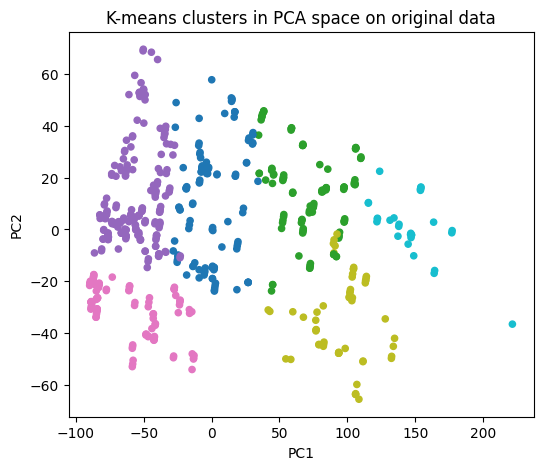

In [63]:
# original data

# getting labels for most reasonable fit
k = 6  # example
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(listeria_numeric_data[only_finite_numeric])

listeria_numeric_data['cluster_kmeans'] = labels

# displaying clustered pca data on the first two components
plt.figure(figsize=(6,5))
plt.scatter(pca_data[:,0], pca_data[:,1], c=labels, cmap='tab10', s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means clusters in PCA space on original data')
plt.show()


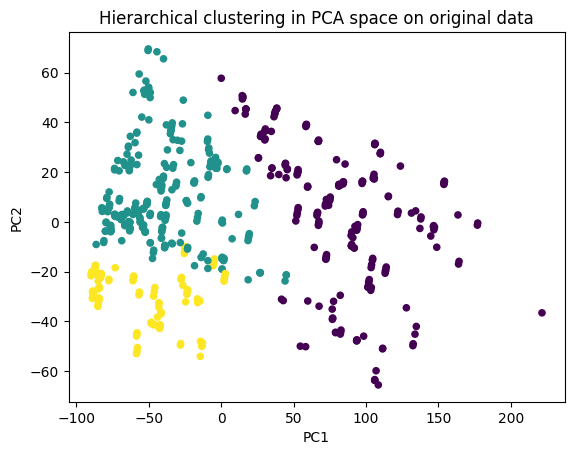

In [45]:
# checking on non-scaled data with heirerarchical clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(listeria_numeric_data[only_finite_numeric])

labels = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(listeria_numeric_data[only_finite_numeric])

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hierarchical clustering in PCA space on original data")
plt.show()

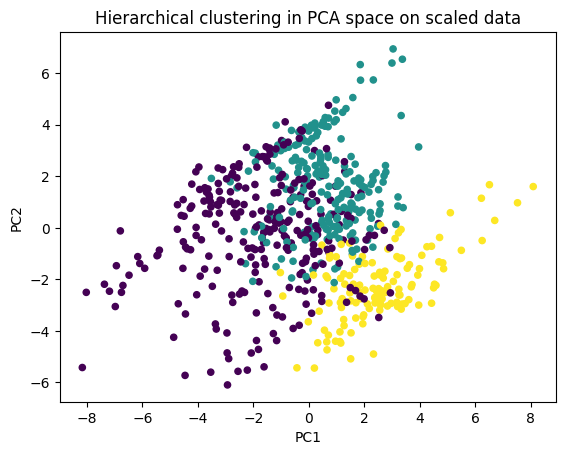

In [46]:
# checking on non-scaled data with heirerarchical clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_listeria_num_data)

labels = AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(scaled_listeria_num_data)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Hierarchical clustering in PCA space on scaled data")
plt.show()

GMM like cllustering

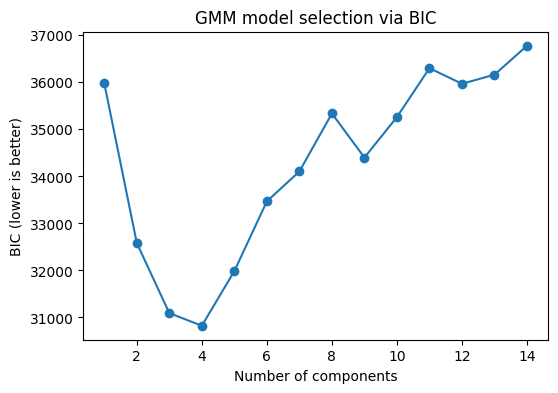

In [47]:
# on scaled data

n_range = range(1, 15)
bics = []

for n in n_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        random_state=42,
        n_init=5
    )
    gmm.fit(scaled_listeria_num_data)
    bics.append(gmm.bic(scaled_listeria_num_data))

plt.figure(figsize=(6,4))
plt.plot(n_range, bics, marker='o')
plt.xlabel("Number of components")
plt.ylabel("BIC (lower is better)")
plt.title("GMM model selection via BIC")
plt.show()


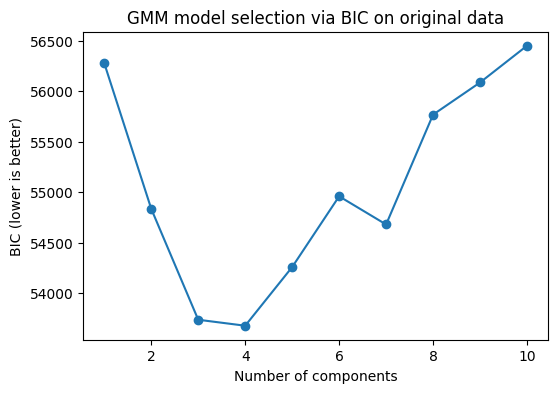

In [48]:
# original data

n_range = range(1, 11)
bics = []

for n in n_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        random_state=42,
        n_init=5
    )
    gmm.fit(listeria_numeric_data[only_finite_numeric])
    bics.append(gmm.bic(listeria_numeric_data[only_finite_numeric]))

plt.figure(figsize=(6,4))
plt.plot(n_range, bics, marker='o')
plt.xlabel("Number of components")
plt.ylabel("BIC (lower is better)")
plt.title("GMM model selection via BIC on original data")
plt.show()


Heatmaps

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


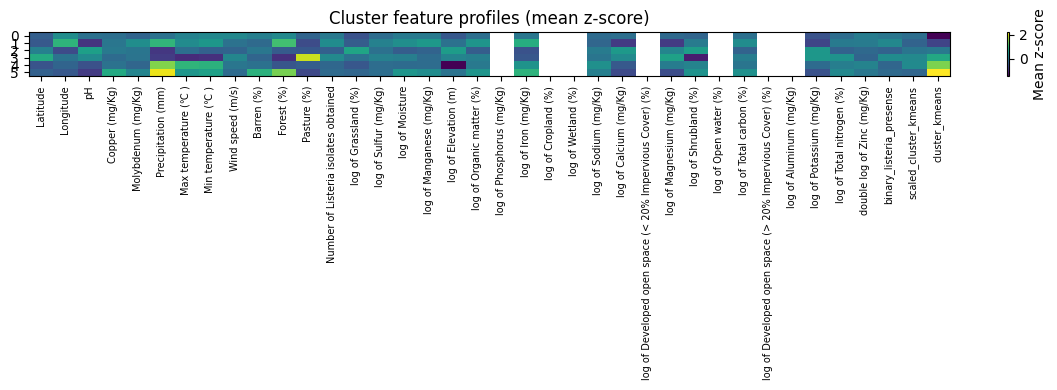

In [49]:
# cluster profile
# standardized features
X = listeria_numeric_data.copy()
Z = (X - X.mean()) / X.std(ddof=0)
dfz = Z.copy()
dfz["cluster"] = listeria_numeric_data["cluster_kmeans"]

cluster_means = dfz.groupby("cluster").mean()

plt.figure(figsize=(12, 4))
plt.imshow(cluster_means, aspect="auto")
plt.colorbar(label="Mean z-score")
plt.xticks(range(cluster_means.shape[1]), cluster_means.columns, rotation=90, fontsize=7)
plt.yticks(range(cluster_means.shape[0]), cluster_means.index)
plt.title("Cluster feature profiles (mean z-score)")
plt.tight_layout()
plt.show()


parwise scatter plots for land cover variables

In [50]:
# selecting which variables to do
top_vars = (
    loadings[["PC1", "PC2"]]
    .abs() # want neg and pos
    .max(axis=1) # picking which ones to pull from and how to decide
    .sort_values(ascending=False)
    .head(6) # grabbing top 6 most influential variables
    .index
)

print(top_vars)

Index(['Precipitation (mm)', 'Forest (%)', 'Pasture (%)',
       'Min temperature (℃ )', 'Longitude', 'Max temperature (℃ )'],
      dtype='object')


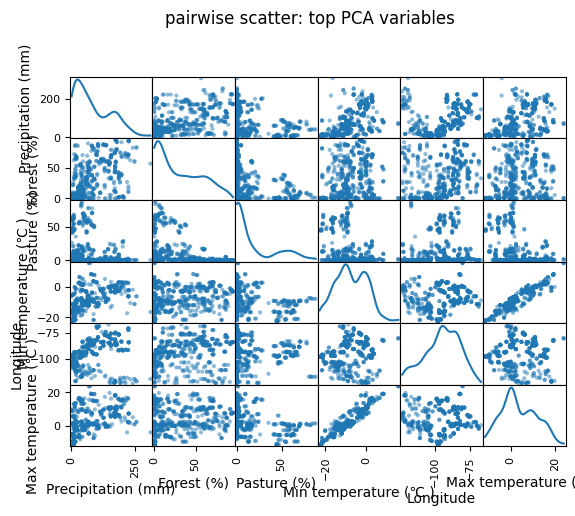

In [51]:
# creating a parwise scatter plot
pd.plotting.scatter_matrix(
    listeria_numeric_data[top_vars],
    diagonal='kde',
    alpha=0.5
)

# plotting 
plt.suptitle("pairwise scatter: top PCA variables", y=1.02)
plt.show()

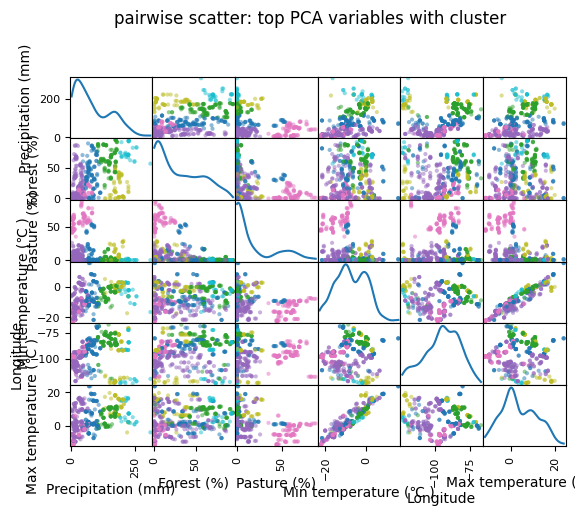

In [52]:
# colloring scater plot by the cluster
pd.plotting.scatter_matrix(
    listeria_numeric_data[top_vars],
    diagonal='kde',
    alpha=0.5,
    c=listeria_numeric_data['cluster_kmeans'],
    cmap='tab10'
)

# plotting 
plt.suptitle("pairwise scatter: top PCA variables with cluster", y=1.02)
plt.show()

Saving data

In [53]:
# saving data with cluster and log info
listeria_numeric_data.to_csv("ListeriaSoil_clean_log.csv")